# Итоговое задание по Проекту 4. Банковский скоринг
***
### Импорт библиотек

In [ ]:
import pandas as pd
from pandas import Series
import numpy as np
import collections

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate# ???

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

#код для kaggle
#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
RANDOM_SEED = 42
current_date = pd.to_datetime('28JUL2020')

Зададим необходимые функции сразу

In [65]:
def IQRhist(col):
    dft = (df.loc[df['Train'] == 1][col])
    median = dft.median()
    perc25 = dft.quantile(0.25)
    perc75 = dft.quantile(0.75)
    IQR = perc75 - perc25
    print('25-й перцентиль: {},'.format(round(perc25,4)), '75-й перцентиль: {},'.format(round(perc75,4)),
          "IQR: {}, ".format(round(IQR,4)), "Границы выбросов: [{f}, {l}].".format(f=round(perc25 - 1.5*IQR,4), l=round(perc75 + 1.5*IQR,4)))
    out_count = dft.apply(
        lambda x: None if x < perc25 - 1.5*IQR or x > perc75 + 1.5*IQR else x).isna().sum()
    print(f'Кол-во выбросов = {out_count}, Процент выбросов среди тренировочного датасета {round((out_count/len(dft)*100),2)}')
    df[col].loc[df[col].between(perc25 - 1.5*IQR, perc75 + 1.5*IQR)].hist(bins=10, range=(dft.min()-5, dft.max()+5),
                                                                          label='IQR')

    plt.legend()

In [5]:
#код для kaggle
#train = pd.read_csv('/kaggle/input/sf-dst-scoring/train.csv')
#test= pd.read_csv('/kaggle/input/sf-dst-scoring/test.csv')
train = pd.read_csv('train.csv')
test= pd.read_csv('test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', train.shape)
display(train.head(2))
print('Размерность тестового датасета: ', test.shape)
display(test.head(2))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


In [6]:
# ВАЖНО! для корректной обработки признаков объединяем трейн и тест в один датасет
train['Train'] = 1 # помечаем где у нас трейн
test['Train'] = 0 # помечаем где у нас тест

df = train.append(test, sort=False).reset_index(drop=True) # объединяем

In [7]:
df.info()
df.columns
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
Train                   0
dtype: int64

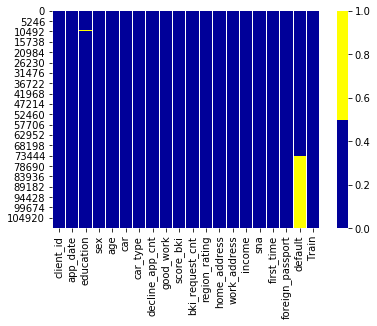

In [8]:
cols = df.columns 
# желтый - пропущенные данные, синий - не пропущенные
colours = ['#000099', '#ffff00'] 
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

Итого после предварительнго анализа можно выделить следующие моменты:
- в тренировочной выборке 73799 клиентов;
- в тестовой - 36349;

Общее количество данных 110148 клиентах.  
Всего 20 переменных:
- 1 - временной ряд;
- 6 бинарных;
- 7 категориальных;
- 8 числовых.

Всего 478 пропусков и все пропуски в переменной education.  
Пропуски в переменной default мы не учитываем, поскольку это целевая переменная и именно эти пропуски мы должны предсказать.   
client_id - уникальный числовой признак, который не несет полезностей.  
В бинарных признаках наше целевая переменная default и искуственно добавленный признак тренировочной части датасета Train.

Описания полей датасета

- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

### Перейдем к первичной обработке датасета

Взглянем поближе на признак app_date

In [10]:
df.app_date.head(5)

0    01FEB2014
1    12MAR2014
2    01FEB2014
3    23JAN2014
4    18APR2014
Name: app_date, dtype: object

Сконветируем формат даты к удобному для работы

In [11]:
df.app_date = pd.to_datetime(df.app_date)
print(df.app_date.head(2))

0   2014-02-01
1   2014-03-12
Name: app_date, dtype: datetime64[ns]


На основе признака app_date создадим новые признаки

In [12]:
# Количество дней, прошедших со дня подачи заявки
df['days_passed'] = (current_date - df.app_date).dt.days

# Месяц подачи заявки
df['app_date_month'] = df.app_date.dt.month

In [13]:
df.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days_passed,app_date_month
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1,2369,2
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1,2330,3


Полученные признаки сгруппируем в три категории по типу их обработки (категориальные, бинарные и числовые) для дальнейшего удобного анализа.

In [14]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
cat_cols = ['app_date_month', 'education', 'home_address', 'work_address', 'sna', 'first_time']
num_cols = ['days_passed', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'region_rating', 'income']

### Детальный анализ по переменным

***

Взглянем на целевую переменную

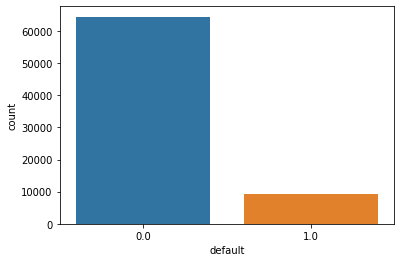

In [15]:
sns.countplot(df.loc[df['Train']==1]['default'])

In [16]:
df.loc[df['Train']==1]['default'].value_counts()

0.0    64427
1.0     9372
Name: default, dtype: int64

Очевидно что выборка распределена неравномерно и недефолтных клиентов заметно больше

Построим графики распределения численных переменных

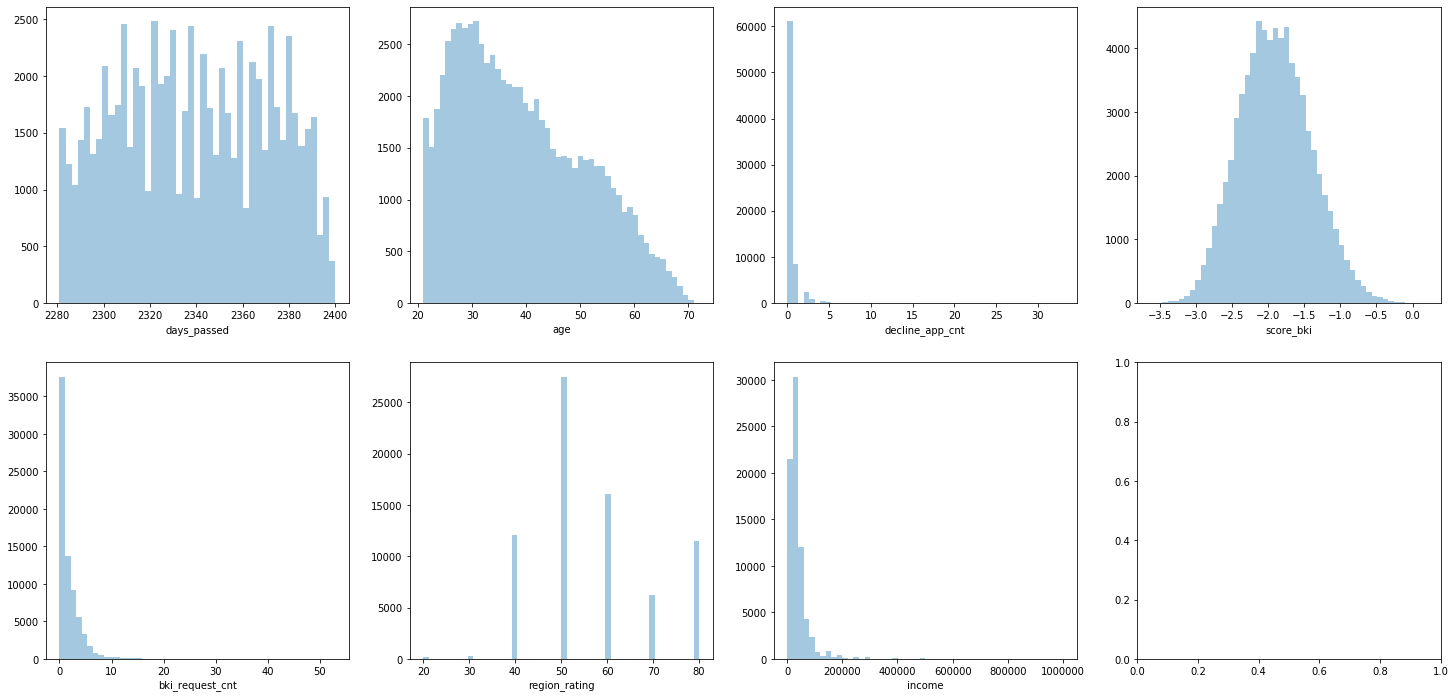

In [17]:
fig, axes = plt.subplots(2, 4, figsize=(25,12))
for col, i in zip(num_cols, range(7)):
    sns.distplot(df.loc[df['Train']==1][col], kde=False, ax=axes.flat[i])

Прологарифмируем переменные, которые вызывают вопросы в распределении, поскольку они либо смещены, либо неравномерны.

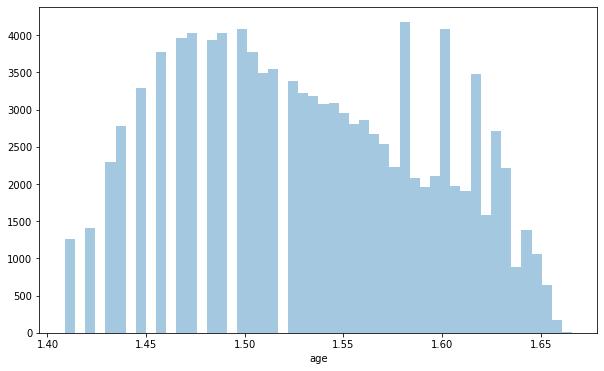

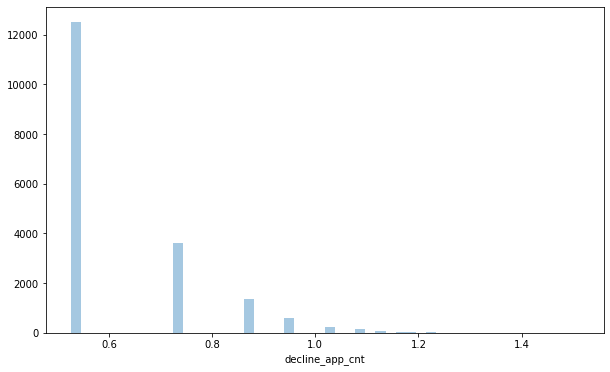

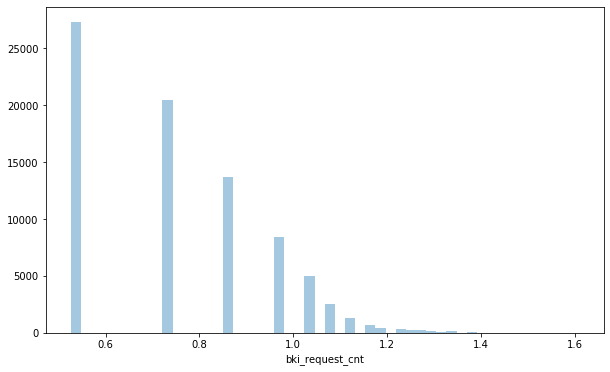

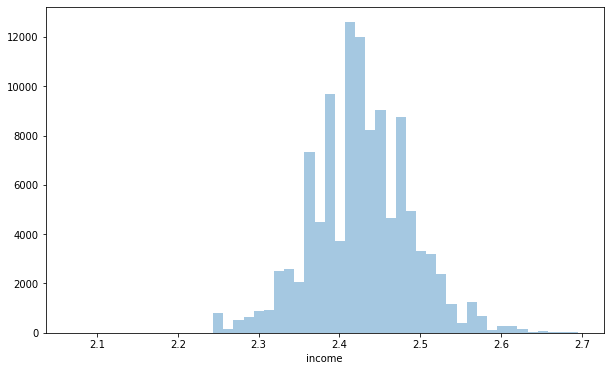

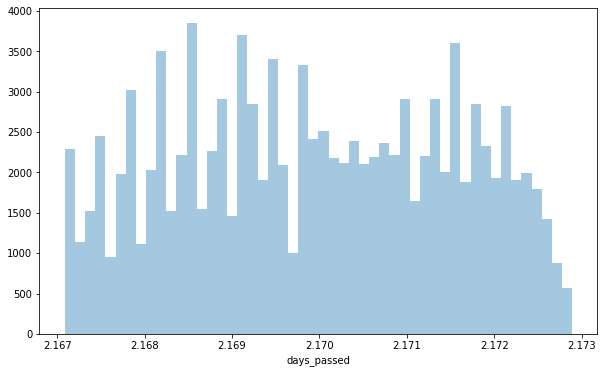

In [20]:
num_cols_log = ['age', 'decline_app_cnt', 'bki_request_cnt', 'income', 'days_passed']
for i in num_cols_log:
    df[i] = np.log(df[i] + 1)
    plt.figure(figsize=(10,6))
    sns.distplot(df[i][df[i] > 0].dropna(), kde = False, rug=False)
    plt.show()

In [21]:
df.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days_passed,app_date_month
0,25905,2014-02-01,SCH,M,1.637663,Y,Y,0.0,0,-2.008753,0.526589,50,1,2,2.379378,4,1,N,0.0,1,2.171410,2
1,63161,2014-03-12,SCH,F,1.628131,N,N,0.0,0,-1.532276,0.869742,50,2,3,2.384372,4,1,N,0.0,1,2.169517,3


Расммотрим признаки по категориям, с учетом логарифмирования и новых значений.

Начнем с чилсловых переменных

### 1. AGE  
#### Возраст

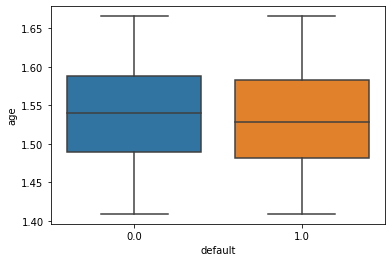

In [25]:
sns.boxplot(x=df[df['Train'] == 1].default, y=df[df['Train'] == 1].age)

### AGE

Недефолтные клиенты в среднем старше дефолтных 
Распределение логнормальное , выбросов нет. 

### 2.decline_app_cnt  
#### Количество отказанных прошлых заявок

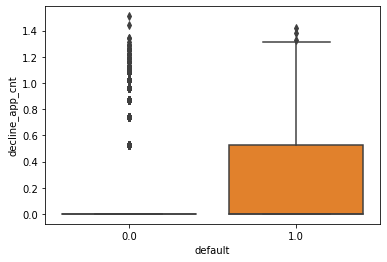

In [40]:
sns.boxplot(x=df[df['Train'] == 1].default, y=df[df['Train'] == 1].decline_app_cnt)

25-й перцентиль: 0.0, 75-й перцентиль: 0.0, IQR: 0.0,  Границы выбросов: [0.0, 0.0].
Кол-во выбросов = 12585, Процент выбросов среди тренировочного датасета 17.05


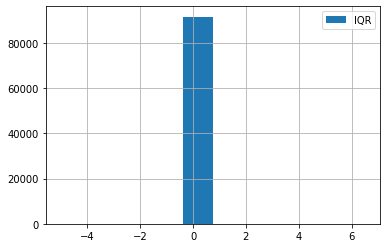

In [54]:
IQRhist('decline_app_cnt')

### decline_app_cnt  

У дефолтных клиентов количество отклоненных заявок выше, чем у недефолтных.  
Как мы видим, даже после логарифмирования, данный признак имеет большое количество выбросов 17% от общего числа значений, причем все остальные значения равны 0.  
Пока что оставим этот признак и вернемся к нему позднее, если будет необходимость.

### 3. bki_request_cnt
#### Количество запросов в БКИ

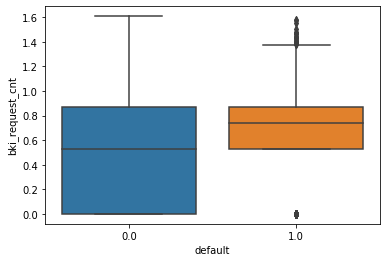

In [55]:
sns.boxplot(x=df[df['Train'] == 1].default, y=df[df['Train'] == 1].bki_request_cnt)

25-й перцентиль: 0.0, 75-й перцентиль: 0.8697416861919439, IQR: 0.8697416861919439,  Границы выбросов: [-1.3046125292879158, 2.17435421547986].
Кол-во выбросов = 0, Процент выбросов среди тренировочного датасета 0.0


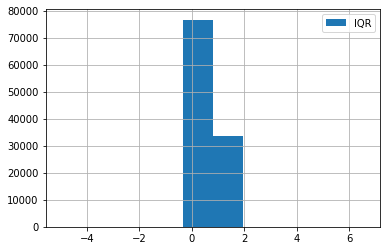

In [56]:
IQRhist('bki_request_cnt')

### bki_request_cnt

Распределение логнормальное, выбросов нет

### 4. score_bki
#### скоринговый балл по данным из БКИ

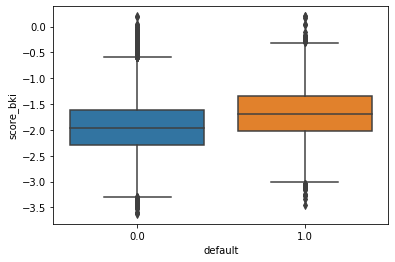

In [57]:
sns.boxplot(x=df[df['Train'] == 1].default, y=df[df['Train'] == 1].score_bki)

25-й перцентиль: -2.259533835, 75-й перцентиль: -1.56983126, IQR: 0.6897025750000001,  Границы выбросов: [-3.2940876975, -0.5352773974999998].
Кол-во выбросов = 351, Процент выбросов среди тренировочного датасета 0.48


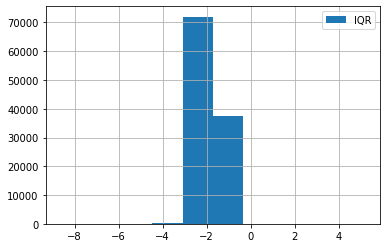

In [58]:
IQRhist('score_bki')

### score_bki

Скоринговый балл в среднем выше у дефолтных клиентов, что довольно необычно (вероятнее всего банк самостоятельно произвел манипуляции с этим признаком, т. к. обычно скоринговый балл положительный от 0 до 850).  
Распределение нормальное. Выбросов не много, не стали удалять

### 5. income

#### доход заемщика

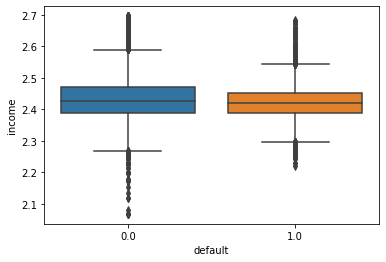

In [61]:
sns.boxplot(x=df[df['Train'] == 1].default, y=df[df['Train'] == 1].income)

25-й перцентиль: 2.3891, 75-й перцентиль: 2.4663, IQR: 0.07722906021905862,  Границы выбросов: [2.2732, 2.5822].
Кол-во выбросов = 1585, Процент выбросов среди тренировочного датасета 2.15


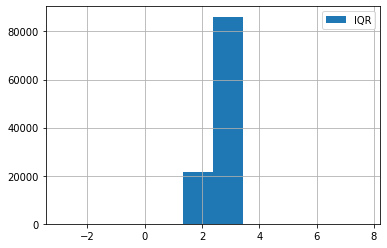

In [64]:
IQRhist('income')

### income: 
Доход недефолтных клиентов выше, чем доход дефолтных.  
Распределение логнормальное, выбросов 2.15 %, поэтому удалять их пока не будем. Построим модель, а потом вернемся к этому вопросу при необходимости.

### 6. days_passed
#### Количество дней, прошедших со дня подачи заявки

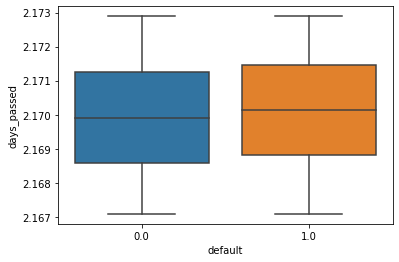

In [66]:
sns.boxplot(x=df[df['Train'] == 1].default, y=df[df['Train'] == 1].days_passed)

25-й перцентиль: 2.1686, 75-й перцентиль: 2.1713, IQR: 0.0027,  Границы выбросов: [2.1645, 2.1754].
Кол-во выбросов = 0, Процент выбросов среди тренировочного датасета 0.0


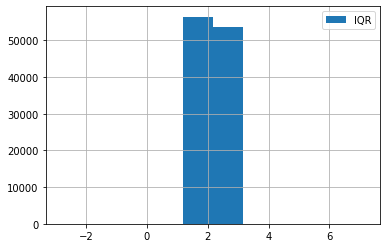

In [67]:
IQRhist('days_passed')

### days_passed

Дефолтные клиенты в среднем оформляли заявки раньше, чем недефолтные. Это может быть связано со множеством факторов, вплоть до эффективности работы системы скоринга в банке в разные моменты времени. Но разница не настолько значительная, чтобы делать какие либо выводы.  
Созданный признак. Распределние логнормальное, выбросов нет

### 7. region_rating
#### Рейтинг региона

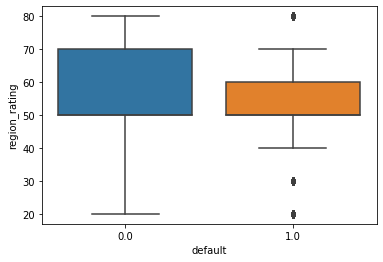

In [68]:
sns.boxplot(x=df[df['Train'] == 1].default, y=df[df['Train'] == 1].region_rating)

25-й перцентиль: 50.0, 75-й перцентиль: 60.0, IQR: 10.0,  Границы выбросов: [35.0, 75.0].
Кол-во выбросов = 11975, Процент выбросов среди тренировочного датасета 16.23


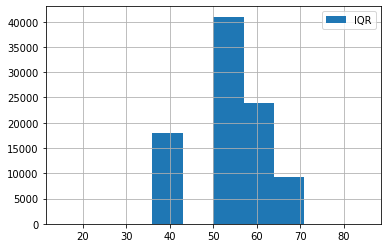

In [69]:
IQRhist('region_rating')

In [70]:
df.region_rating.value_counts()

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64

###  region_rating

Среднее значение в данном случае больше у недефолтных клиентов, в то время как медианы равны.  
Распределение скорее логнормальное. Выбросов много, причем бльшая часть находится справа,в принципе можно было бы удалить левую сторону выбросов, но посмотрим сначала как сработает модель без удаления потом удалим. Вполне возможно перенести его из числового признака в категориальный.

#### Далее рассмотрим бинарные признаки

sex, car, car_type, good_work, foreign_passport

Преобразуем все признаки использовуя LabelEncoder

In [77]:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
# убедимся в преобразовании    
df.head(2)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,Train,days_passed,app_date_month
0,25905,2014-02-01,SCH,1,1.637663,1,1,0.0,0,-2.008753,0.526589,50,1,2,2.379378,4,1,0,0.0,1,2.171410,2
1,63161,2014-03-12,SCH,0,1.628131,0,0,0.0,0,-1.532276,0.869742,50,2,3,2.384372,4,1,0,0.0,1,2.169517,3


### Далее рассмотрим категориальные признаки

app_date, education, home_address, work_address, sna

### Education

#### Уровень образования

Для наглядности начнем с признака с пропусками на графике и заполним пропуски в данной переменной

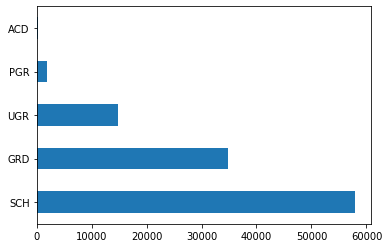

In [81]:
df['education'].value_counts().plot.barh()

Заполним пропуски значением, которое встречается чаще всего

In [83]:
c = collections.Counter(df['education'])

df['education'].fillna(c.most_common()[0][0], inplace=True)

In [86]:
df[df['Train'] == 1].isnull().sum().sum()

0

Пропуски устранены

In [91]:
df[df['Train'] == 1].app_date.value_counts()

2014-03-18    1018
2014-03-17     911
2014-03-19     909
2014-03-31     904
2014-04-07     882
              ... 
2014-04-20     243
2014-01-07     228
2014-01-03     193
2014-01-02     137
2014-01-01      43
Name: app_date, Length: 120, dtype: int64

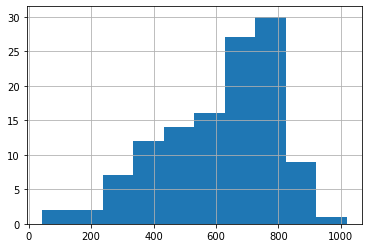

In [92]:
df[df['Train'] == 1]['app_date'].value_counts().hist()

In [93]:
# Выясняем начало и конец периода нашего датасета - это 1 января и 30 апреля 2014 года
start = df.app_date.min()
end = df.app_date.max()
start,end

(Timestamp('2014-01-01 00:00:00'), Timestamp('2014-04-30 00:00:00'))

Таким образом, можно выяснить влияет ли время подачи заявки на число дефолтов

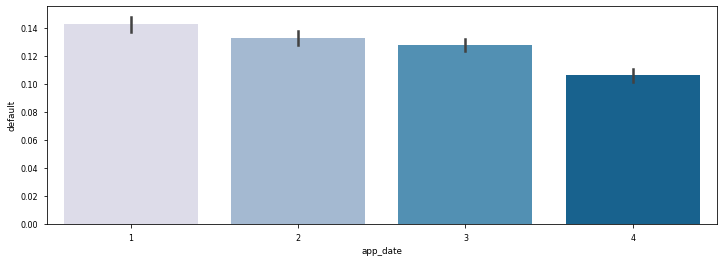

In [108]:

plt.subplots(figsize=(12, 4))
color_text = plt.get_cmap('PuBu')
sns.barplot(data=df[df['Train']==1], x=df.loc[df['Train']==1,'app_date'].dt.month, y='default', palette="PuBu");

Среднее число дефолтов по тренировочному датасету отрицательно коррелирует с месяцем подачи заявки.  
и снижается к 4 месяцу, вполне возможно из-за внесения изменений во внутренние алгоритмы банка

## Визуализация

Построим матрицу корреляций числовых признаков

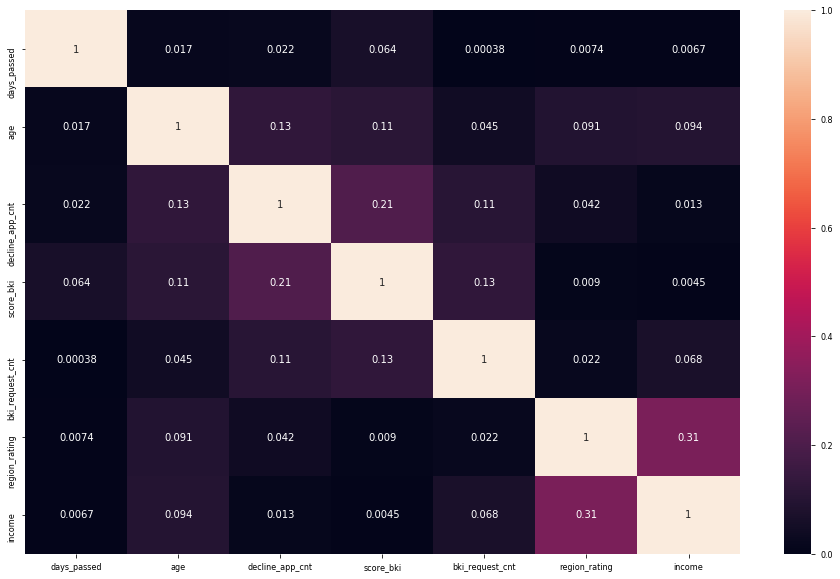

In [109]:
plt.figure(figsize=(16,10))
sns.heatmap(df[df['Train']==1][num_cols].corr().abs(), vmin=0, vmax=1, annot=True)

Высокой корреляции между признаками не наблюдается

## Преобразование бинарных и категориальных переменных

Преобразуем категориальные переменные при помощи OneHotEncoder

In [110]:
cat = OneHotEncoder(sparse = False).fit_transform(df[cat_cols].values)

print(cat.shape)

(110148, 23)


In [120]:
education_dummy = pd.get_dummies(df[df['Train']==1]['education'])
education_dummy.head()

,ACD,GRD,PGR,SCH,UGR
0,0,0,0,1,0
1,0,0,0,1,0
2,0,0,0,1,0
3,0,0,0,1,0
4,0,1,0,0,0


## Значимость непрерывных переменных

Text(0.5, 0, 'F-value')

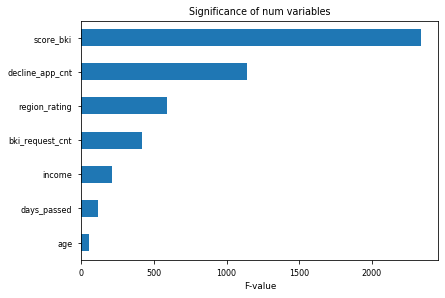

In [113]:
imp_num = Series(f_classif(df[df['Train']==1][num_cols], df[df['Train']==1]['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

## Значимость бинарных и категориальных переменных

Text(0.5, 1.0, 'Significance of bin variables')

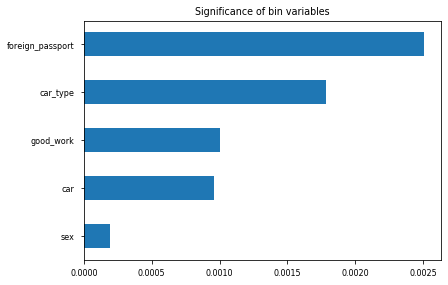

In [114]:
# Значимость бинарных признаков

imp_bin = Series(mutual_info_classif(df[df['Train']==1][bin_cols], df[df['Train']==1]['default'],
                                     discrete_features =True), index = bin_cols)
imp_bin.sort_values(inplace = True)
imp_bin.plot(kind = 'barh')
plt.title('Significance of bin variables')

In [119]:
index = pd.concat([df[df['Train']==1][new_cat_cols], education_dummy], axis=1)
index

,app_date_month,home_address,work_address,sna,first_time,ACD,GRD,PGR,SCH,UGR
0,2.0,1.0,2.0,4.0,1.0,0,0,0,1,0
1,3.0,2.0,3.0,4.0,1.0,0,0,0,1,0
2,2.0,1.0,2.0,1.0,4.0,0,0,0,1,0
3,1.0,2.0,3.0,1.0,3.0,0,0,0,1,0
4,4.0,2.0,3.0,1.0,4.0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
110143,NaN,NaN,NaN,NaN,NaN,0,0,0,1,0
110144,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0
110145,NaN,NaN,NaN,NaN,NaN,0,1,0,0,0
110146,NaN,NaN,NaN,NaN,NaN,0,0,0,0,1


Text(0.5, 1.0, 'Significance of cat variables')

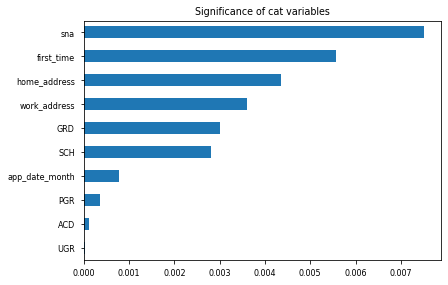

In [121]:
# Значимость категориальных признаков

new_cat_cols = ['app_date_month', 'home_address', 'work_address', 'sna', 'first_time']

imp_cat = pd.Series(mutual_info_classif(pd.concat([df[df['Train']==1][new_cat_cols], education_dummy], axis=1),df[df['Train']==1]['default'], discrete_features =True),
                    index = pd.concat([df[df['Train']==1][new_cat_cols], education_dummy], axis=1).columns)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')
plt.title('Significance of cat variables')

Исходя из данных графиков можно сделать вывод о малозначимости признака sex и age. А также мы можем увидеть значимость различных степеней образования на наш результат и наибольший вклад приносит признак GRD (graduate).

### Стандартизация?

## Подготовка данных к машинному обучению

In [122]:
train_data = df.query('Train == 1').drop(['Train', 'client_id'], axis=1)
test_data = df.query('Train == 0').drop(['Train', 'client_id'], axis=1)

y = train_data.default.values            # наш таргет
X = train_data.drop(['default'], axis=1)
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((36349, 21), (73799, 21), (73799, 20), (59039, 20), (14760, 20))

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2)

x_tr = poly.fit_transform(train[num_cols].values)
y_test = poly.fit_transform(test[num_cols].values)

Стандартизируем числовые переменные

In [ ]:
# Scaling num variables

x_num = StandardScaler().fit_transform(x_tr)
y_num = StandardScaler().fit_transform(y_test)
print(x_num)
print(y_num)

И объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [ ]:
# Merge

X = np.hstack([x_num, train[bin_cols].values, x_cat])
Y = train['default'].values

id_test = test.client_id
test = np.hstack([y_num, test[bin_cols].values, y_cat])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42, shuffle = True)

## Регуляризация

In [ ]:
from sklearn.model_selection import GridSearchCV

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)
model = LogisticRegression()
model.fit(X_train, y_train)

clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

print('Лучший penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Обучим модель

In [ ]:
lgr = LogisticRegression(penalty = 'l2', C=166.81005372000593, max_iter=500)
lgr.fit(X_train, y_train)

In [ ]:
probs = lgr.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Обучим модель на всем датасете

In [ ]:
lgr = LogisticRegression(penalty = 'l2', C=166.81005372000593, max_iter=500)
lgr.fit(X, Y)
probs = lgr.predict_proba(test)
probs = probs[:,1]

In [ ]:
my_submission = pd.DataFrame({'client_id': id_test, 
                            'default': probs})
#my_submission.to_csv('submission.csv', index=False)

my_submission